<center>

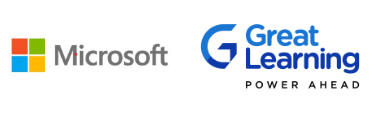
</center>

<center>
<h1><b>Text-to-Text tasks with Azure Open AI</b>
</center>

# Objectives

- Illustrate prompt engineering for text-to-text tasks using Azure Open AI.
- Build and evaluate LLMs for text-to-text tasks using appropriate metrics (e.g., ROUGE score and BERTscore).

# Text $→$ Text generation

A text $→$ text generation task involves the generation of a relevant response to the input depending on the task at hand. Examples include:

 - Summarization (abstractive or extractive)
 - Question Answering (including multiple choice)
 - Matching a premise to a hypothesis

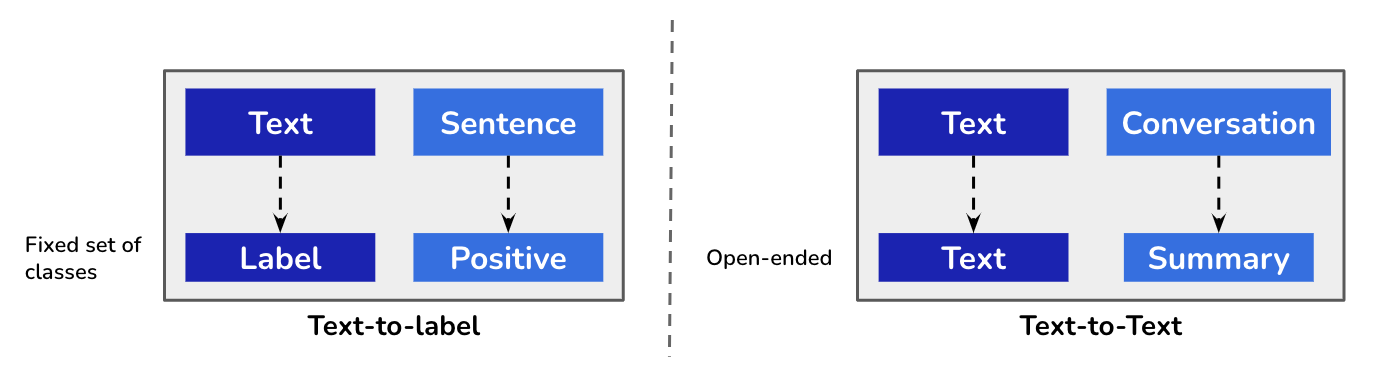

The key thing to note here is that unlike the case of text classification where the labels belong to a known (i.e., pre-defined) set, text-text generation is more abstract. For example, there is no "standard" summary of a customer service request; the quality of summary varies with the human tasked with creating the summary. This lack of standard labels when generating text output given input text complicates the performance evaluation of LLMs on these tasks.

## Operationalizing Generative AI - A Recap

While evaluation of text-to-text tasks requires new evaluation metrics, the overall process of creating a generative AI solution remains the same as that we saw for classification tasks.

Specifically, solutions for text $\rightarrow$ text tasks can be built using LLM machinery using the following steps.

>*Step 1:* Frame the task as a combination of objective and metric.
>
>*Step 2:* Assemble data (i.e., examples and gold examples).
>
>*Step 3:* Design prompts using best practises such as few-shot, CoT, ReAct and evaluate them on gold examples.

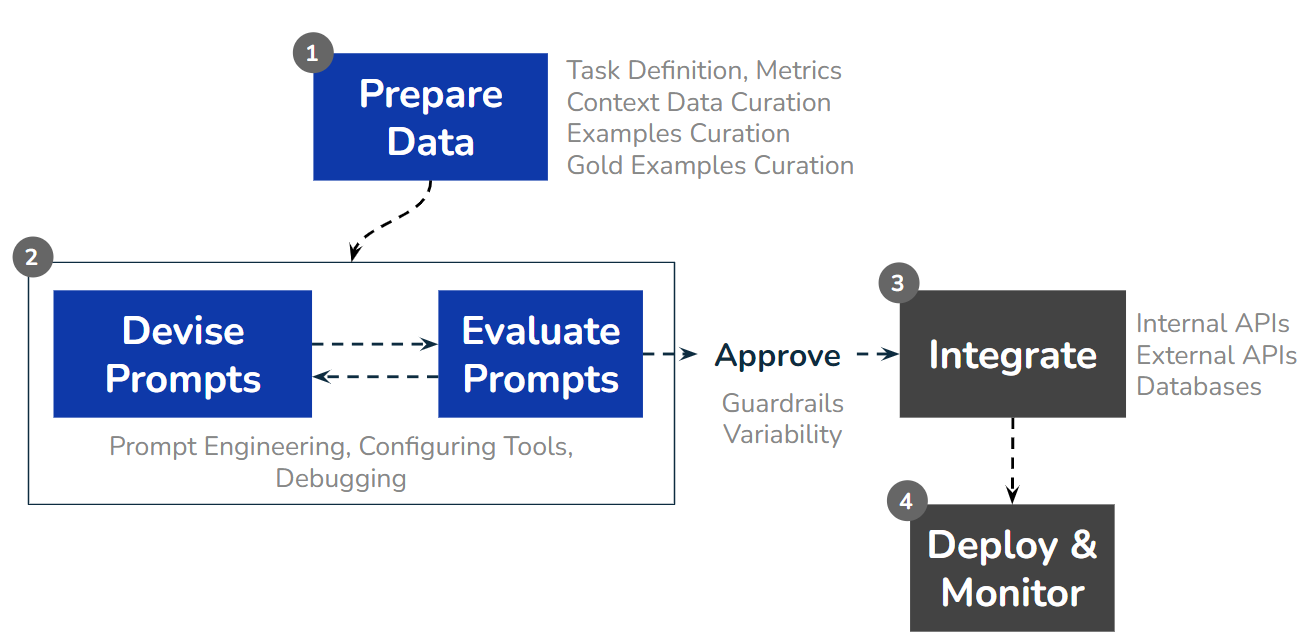

In this notebook, we will take a closer look at two important text $→$ text tasks (summarization and question-answering), setting up the problems, metrics, evaluations with a view to devise prompts that achieve high performance on these evaluations.

# Setup

This notebook needs to be executed with a GPU runtime since we load a transformer model to disk and use it to evaluate text-to-text tasks. Transformer models benefit from parallel execution offered by a GPU runtime and can have a significant impact on execution times (for e.g., code in this notebook runs up to 4 times faster witha GPU). Follow the screenshots below to create a GPU runtime on a Colab instance.

*Step 1:*

Select the `Runtime` option from the main menu and select the `Change runtime type` from the dropdown.

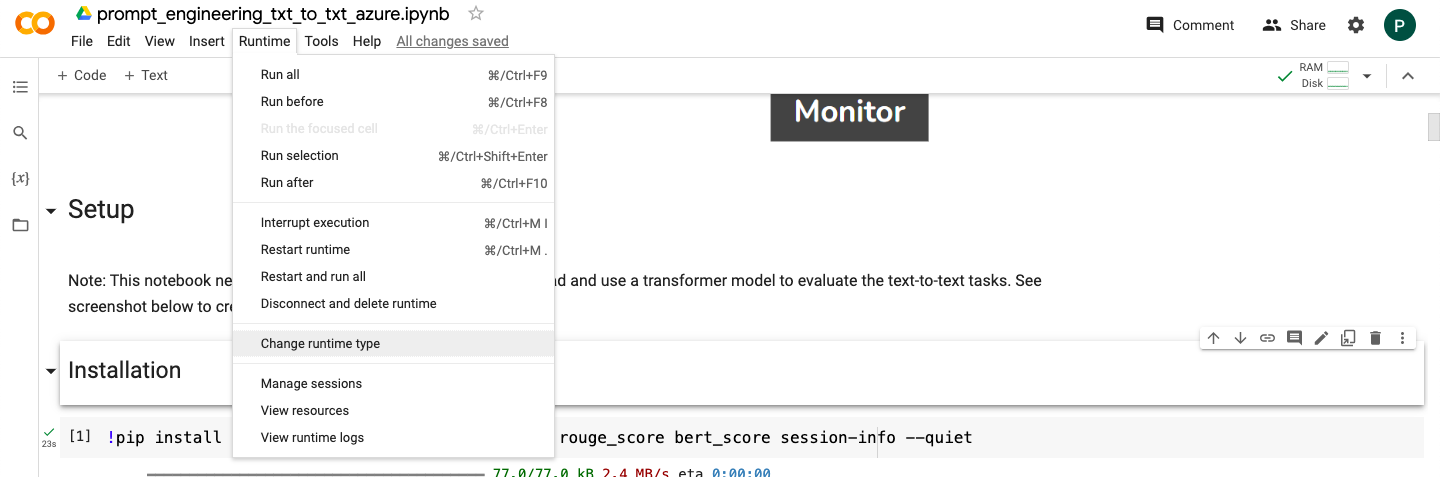

Select `T4 GPU` from the options presented under Hardware accelerator.

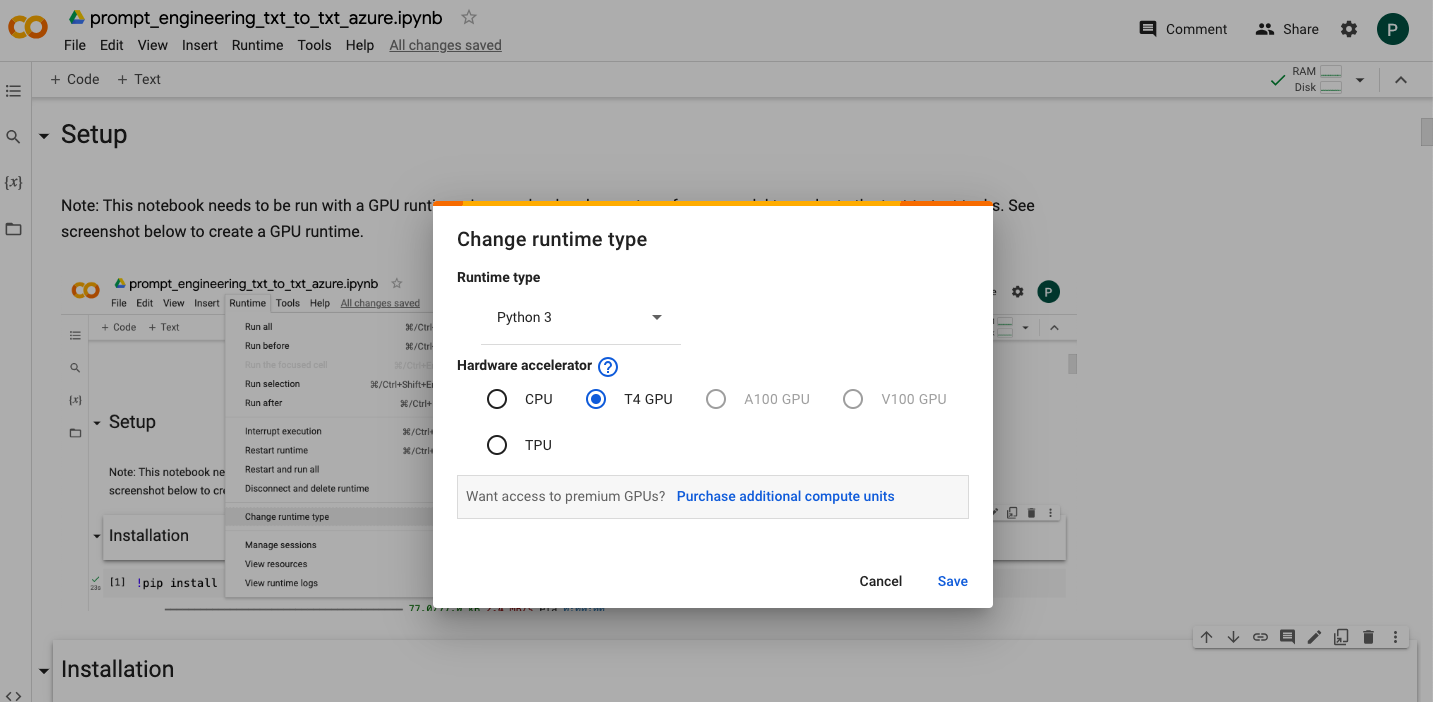

You should now see the T4 GPU mentioned in the runtime logo (screenshot below).

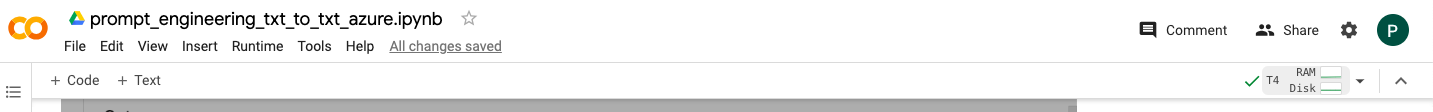

## Installation

In [10]:
%pip install openai tiktoken datasets \
             evaluate rouge_score bert_score --quiet

Note: you may need to restart the kernel to use updated packages.


## Imports

In [11]:
import openai
import json
import tiktoken
import evaluate

import numpy as np
import pandas as pd

from datasets import load_dataset
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split

## Authentication

In [12]:
with open('config.json', 'r') as az_creds:
    data = az_creds.read()

In [13]:
creds = json.loads(data)

In [14]:
openai.api_key = creds["AZURE_OPENAI_KEY"]
openai.api_base = creds["AZURE_OPENAI_ENDPOINT"]
openai.api_type = creds["AZURE_OPENAI_APITYPE"]
openai.api_version = creds["AZURE_OPENAI_APIVERSION"]

In [15]:
chat_model_id = creds["CHATGPT_MODEL"]

## Utilities

Token counter to keep track of the completion window available in the prompt.

In [16]:
def num_tokens_from_messages(messages):

    """
    Return the number of tokens used by a list of messages.
    Adapted from the Open AI cookbook token counter
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    # Each message is sandwiched with <|start|>role and <|end|>
    # Hence, messages look like: <|start|>system or user or assistant{message}<|end|>

    tokens_per_message = 3 # token1:<|start|>, token2:system(or user or assistant), token3:<|end|>

    num_tokens = 0

    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))

    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>

    return num_tokens

## Task 1: Summarization

### Step 1: Define objectives and metrics

There are two methods to summarize input text:
- Abstractive (output: a gist of the input).
- Extractive (output: a selection of key sentences from the input).

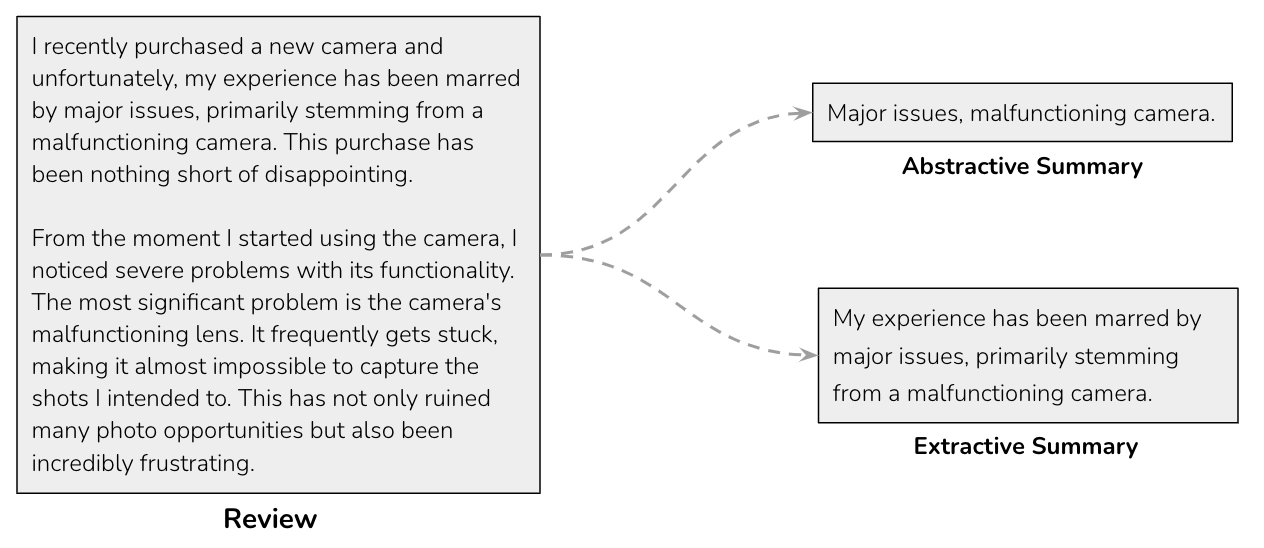

The objective in abstractive summarization is to generate a clear summary of the input text, while that of extractive summarization is to generate a selection of appropriate sentences that summarize the input text.

In order to evaluate model predictions (i.e., AI generated summaries), we compare the model predictions with the ground truth on a sample of human-annotated gold examples. However, given the subjective nature of model predictions, we need new metrics to evaluate summarization outputs: ROUGE and BERTScore.

Apart from these two automated metrics, another method used to judge the quality of a summary is to use another LLM to assign a quality rating to the summary. Using an LLM to avaluate another LLM offers further flexibility in evaluation. For example, we could also specify specific attributes of an ideal summary (for e.g., conciseness, clarity of exposition).

Let us now look at each of these metrics in greater detail.

#### Recall-Oriented Understudy for Gisting Evaluation (ROUGE)

ROUGE takes a exact match approach to compare the prediction from the model with the human reference summary by relying on matches of n-grams between the two (depicted in the figure below).

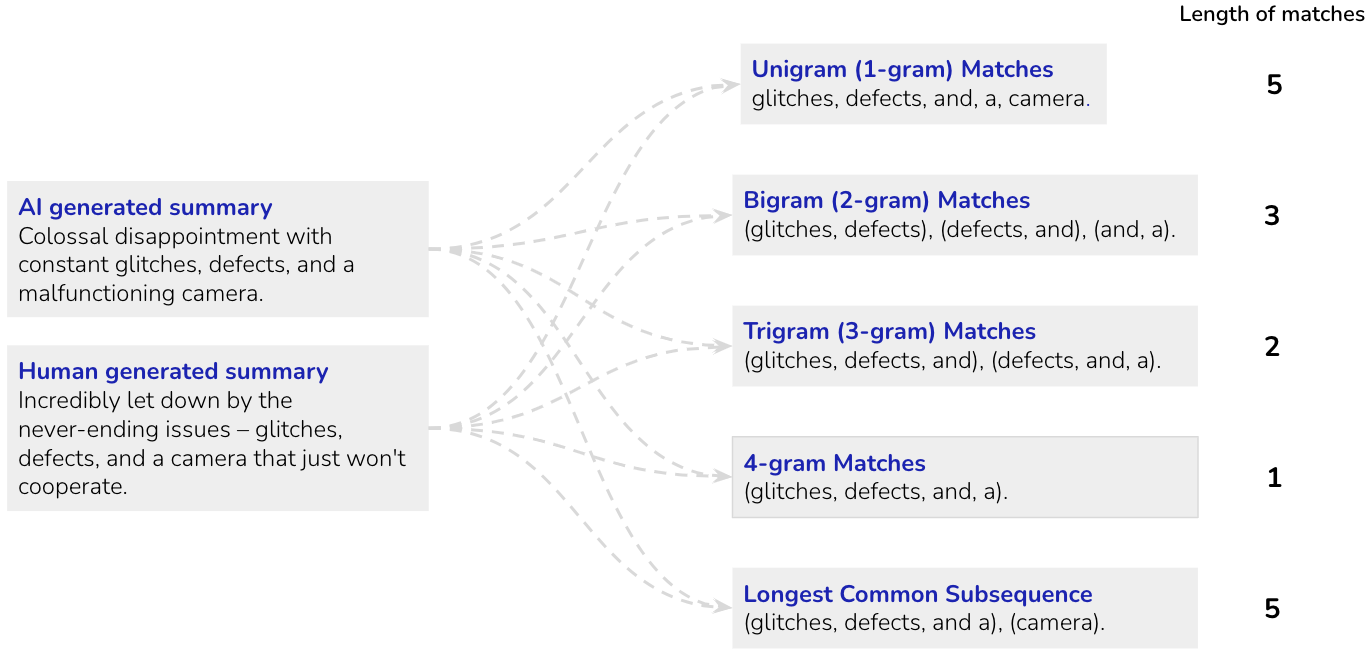

The $\text{ROUGE}_{N}$ score is computed using the ratio of the number of n-gram matches to the total number of n-grams in the human generated summary. However, we still have to make a choice whether unigram, bigram, or any other n-gram should be used.

To solve this conundrum, a common variant of ROUGE that is used to generate a comparison metric is $\text{ROUGE}_{\text{L}}$, where we first compute the recall and precision of the longest common subsequence and then compute the harmonic mean of these values (punctuation and case of the word are disregarded).

In [17]:
ai_generated_summary = "Colossal disappointment with constant glitches, defects, and a malfunctioning camera."
human_generated_summary = "Incredibly let down by the never-ending issues – glitches, defects, and a camera that just won't cooperate."

As seen in the figure above, the length of the largest common subsequence (LCS) between the two summaries is 5. The number of unigrams in the AI-generated summary is 10 and the number of unigrams in the human generated summary is 17.

We define the recall of the LCS as 5/17 and the precision of the LCS as 5/10 (notice the parallel with the precision and recall measures used to evaluate classification tasks).

From these measures, we can compute $\text{ROUGE}_{\text{L}}$ as the F1 score associated with the precision and recall like so:

In [18]:
r_lcs, p_lcs = 5/17, 5/10
(2 * r_lcs * p_lcs)/(r_lcs + p_lcs) # rouge-L

0.37037037037037035

One important limitation of ROUGE is that it accounts for exact matches. This means that a summary that uses semantically close words would receive a poor score despite capturing the intent of the human summary. Hence, ROUGE is usually used for extractive summarization.

ROUGE values close to 1 indicate that the AI-generated text is close to the text generated by a human.

#### BERTScore

BERTScore is ideal in situations where abstractive summarization is the objective (as is in this case). To illustrate the computation of the BERTScore, consider the following two summary outputs (one from a generative AI model and another from a human).

In [19]:
ai_generated_summary = "Major issues, malfunctioning camera."
human_generated_summary = "Severely disappointed, constant problems."

In [20]:
print(ai_generated_summary)
print(human_generated_summary)

Major issues, malfunctioning camera.
Severely disappointed, constant problems.


Look at the two summaries presented above. Though the choice of words is not exactly the same, both are close in intent. In order to capture intent, we use specific models that encode the semantic meaning of words used in the models in a mathematical space where we can measure the distance between the words used. Since distances can be computed, if two words are close to each other in this mathematical space (i.e., less distance), we can infer that these two words are close in meaning.

Models that encode this mapping, that is, models that associate words with a list of numbers (called *vectors*) that define positions of the words in a mathematical space are referred to as [*embedding models*](https://projector.tensorflow.org/). Embedding models are precursors to language models and are a crucial component of how we represent the semantic meaning of words used in text.

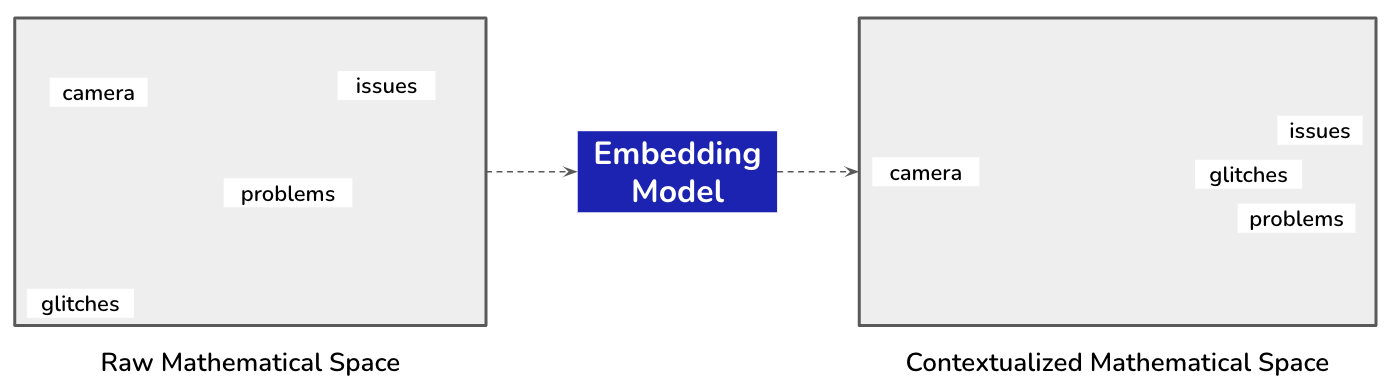

BERTScore uses one such pre-trained embedding model (i.e., Bi-directional Encoder Representation from Transformers - BERT) to:
- map individual words in sentences (in both the AI summary and the human summary) to vectors.
- compute pairwise similarity between all possible pairs of words using these vectors.

Once pairwise similarities are estimated, we use these similarities to compute precision and recall for each word as demonstrated in the following figure.

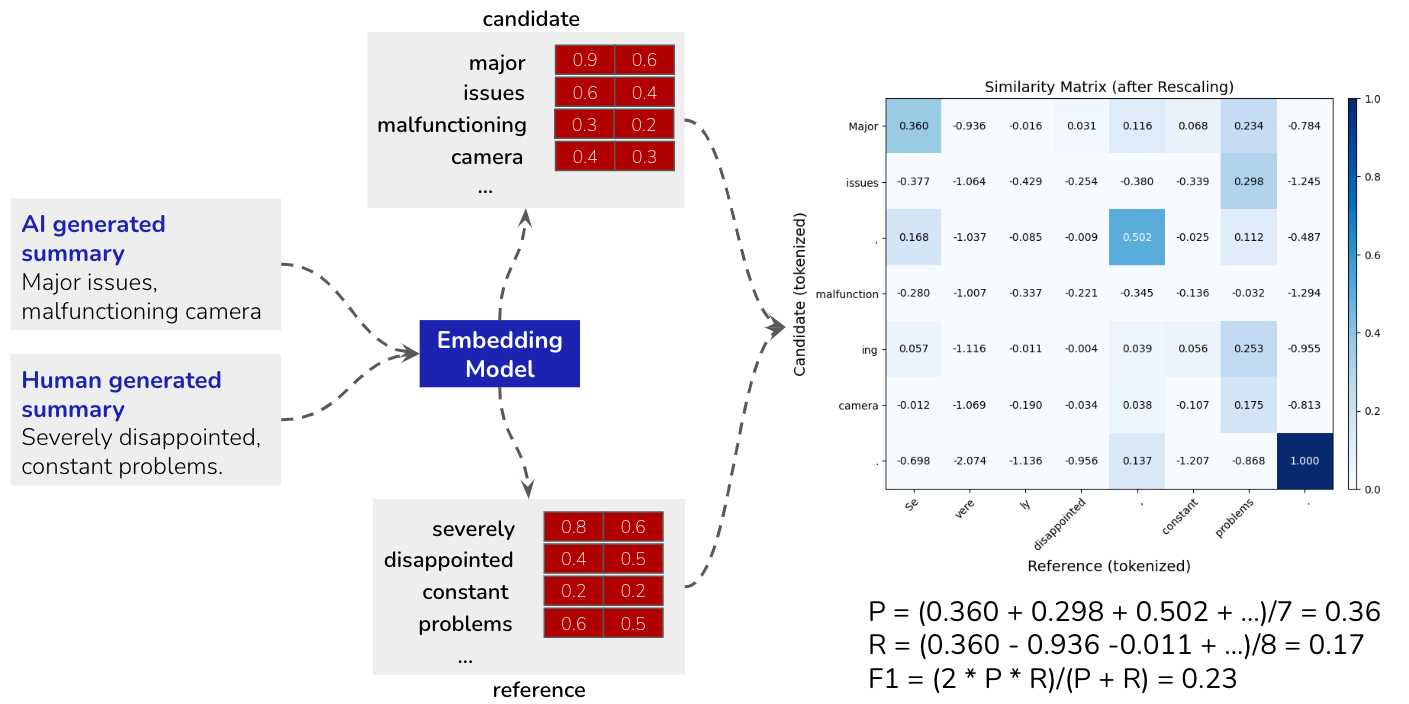

As seen in the figure above, the candidate text (i.e., the AI-generated summary) and the reference text (i.e., the human generated summary) are tokenized and assigned a numeric representation. In this representation, tokens that are correlated with each other lie close to each other (in the space defined by the numeric representation). All pairwise correlations between the tokens of the candidate and the reference are then collected in a table.

For precision ($P$), we average the maximum correlation scores for each token in the *candidate*. For recall ($R$), we average the maximum correlation scores for each token in the *reference*. The F1 score is estimated as: $(2 \times P \times R)/(P+ R)$.

We report the F1 score as the BERTScore. As with ROUGE, BERTScores close to 1 are considered ideal (i.e., the AI-generated text is close to one that is produced by a human).

In [21]:
bert_scorer = evaluate.load("bertscore")

In [22]:
bert_scorer.compute(
    predictions=[ai_generated_summary],
    references=[human_generated_summary],
    lang="en",
    rescale_with_baseline=True
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.363994300365448],
 'recall': [0.17047356069087982],
 'f1': [0.26662349700927734],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.40.2)-rescaled'}

#### LLM rating LLM output

Another commonly used method to automate evaluations is to use a different model (e.g., GPT-4, LLaMA2) to evaluate the output from the model used to execute the text-to-text task (in this case GPT-3.5). The figure below illustrates the steps involved for the case where a summary is generated for the input text.

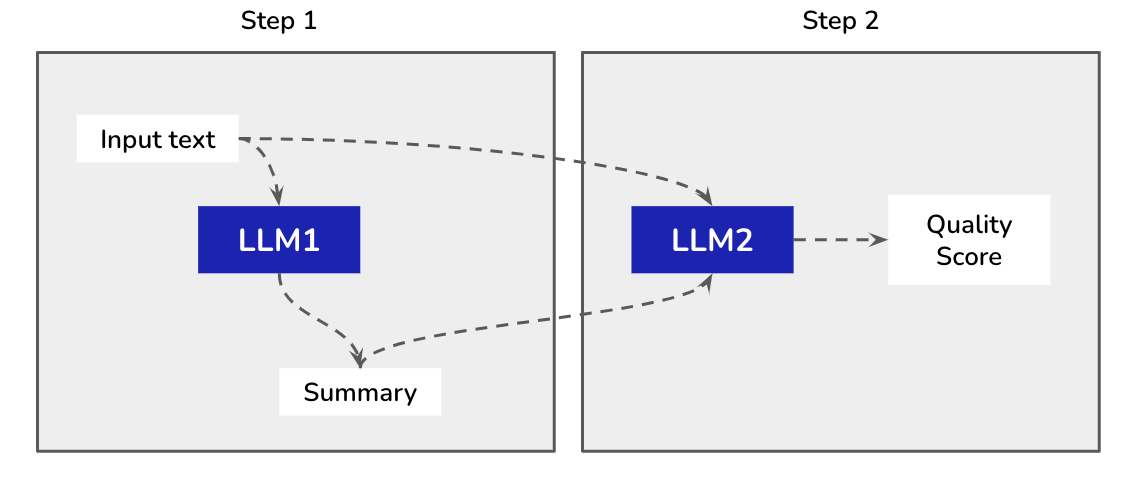

Approaches to using an LLM to evaluate the output of another LLM is an active area of research and initiatives to build standards are still nascent (e.g., [Open AI Evals](https://github.com/openai/evals), [LangChain Evaluators](https://python.langchain.com/docs/guides/evaluation/string/) and [RAGAs](https://github.com/explodinggradients/ragas)).

As an example, consider that we are using an LLM to summarize customer reviews (as is the case in the examples for ROUGE and BERTScore). The following system message and the user message template could be used to prompt a 'rating' LLM based on the output of the 'summarization' LLM.

In [23]:
rater_system_message = """
You are tasked with rating AI-generated summaries of customer reviews.
You will be presented a review and an AI generated summary of the review as the input.
In the input, the review will begin with ###Review while the AI generated summary will begin with ###Summary.

Instructions:
1. Carefully observe the review and its AI-generated summary presented in the input
2. Rate the quality of the summary generated by the AI system on a scale of 1 to 5, 1 being low quality and 5 being high quality.
Note that the AI system was asked to generate a concise summary reflecting the most important points mentioned in the review.
In your rating, focus your assessment only on whether the summary was an accurate, concise reflection of key points in the review.

Please do not explain your rating, the output should only be the rating between 1 to 5.
"""

In [24]:
rater_user_message_template = """
###Review
{review}

###Summary
{summary}
"""

In [25]:
customer_review = """
I recently purchased a new camera and unfortunately, my experience has been marred by major issues, primarily stemming from a malfunctioning camera. This purchase has been nothing short of disappointing.

From the moment I started using the camera, I noticed severe problems with its functionality. The most significant problem is the camera's malfunctioning lens. It frequently gets stuck, making it almost impossible to capture the shots I intended to. This has not only ruined many photo opportunities but also been incredibly frustrating.

Additionally, the camera's autofocus system seems to be erratic, often struggling to focus properly, resulting in blurry and unusable images. This issue, combined with the lens problem, has made photography a frustrating and unreliable endeavor.

The camera's battery life is also below par, and I find myself constantly needing to recharge it, which is inconvenient when I'm on the go.

Overall, my experience with this camera has been highly unsatisfactory due to the major issues, primarily the malfunctioning camera, which has made it difficult to capture quality photos. I'm now considering contacting customer support to address these issues, but I can't help but feel disappointed with this purchase.

"""

In [26]:
ai_generated_summary = "Major issues, malfunctioning camera."

In [27]:
prompt = [
    {
        'role': 'system',
        'content': rater_system_message
    },
    {
        'role': 'user',
        'content': rater_user_message_template.format(
            review=customer_review,
            summary=ai_generated_summary
        )
    }
]

In [28]:
response = openai.ChatCompletion.create(
    deployment_id=chat_model_id,
    messages=prompt,
    temperature=0
)

In [29]:
response['choices'][0]['message']['content']

'2'

### Step 2: Assemble data

With the objective and metrics out of the way, let us now assemble the data for this use case. As in the case text classification, a dataset is a task-specific subset of a corpus.

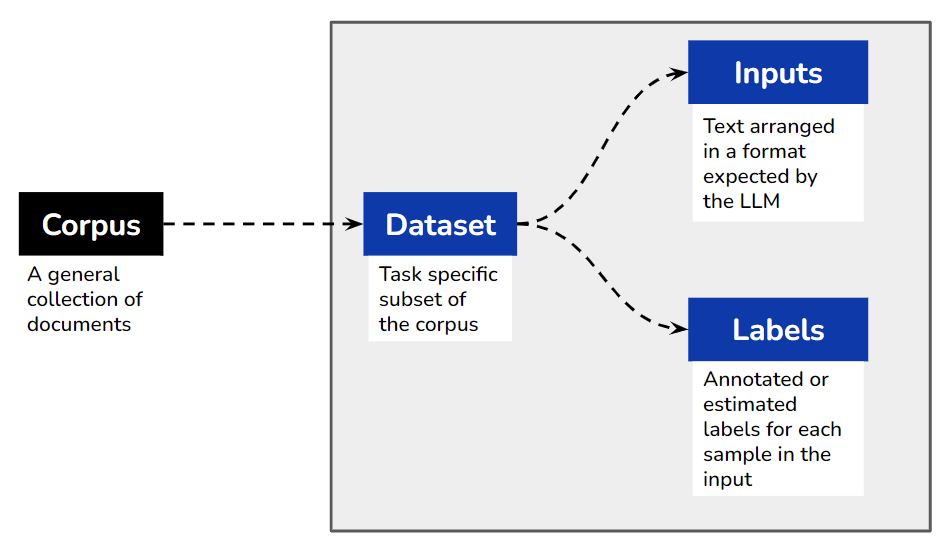

The key difference here is that the labels are not drawn from a predefined distribution. Construction of labels for text $→$ text tasks involves more effort, usually requiring multiple labelers that [brings its own challenges](https://www.databricks.com/blog/2023/04/12/dolly-first-open-commercially-viable-instruction-tuned-llm).

For the abstractive summarization exercise, we use a [dataset of conversations and their summaries](https://huggingface.co/datasets/knkarthick/dialogsum), where each dialogue was summarized by a human. These dialogues belong to a wide variety of topics (7434 in total). We use this dataset to showcase how custom datasets should be prepared and used for prompt engineering.

In [30]:
dataset = load_dataset("knkarthick/dialogsum")

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [31]:
len(dataset['train'])

12460

In [33]:
dialogue_summary_train_df = dataset['train'].to_pandas()

In [34]:
dialogue_summary_train_df.sample(5)

,id,dialogue,summary,topic
10757,train_10757,#Person1#: I really need to apply for a drivin...,#Person2# asks for #Person1#'s ID when helping...,a driving permit
9845,train_9845,#Person1#: Who knows the answer to the problem...,Mr. Brooks asks Melanie to give the correct an...,bathroom
10794,train_10794,"#Person1#: excuse me, is this the way to the G...",#Person1# is going to the Great Wall but is in...,giving directions
2901,train_2901,#Person1#: I was told that your company had be...,#Person1# wants to furnish their new office bu...,business offer
8048,train_8048,"#Person1#: Judg, I haven't seen you in weeks. ...",Judg went on a special field trip to Florida. ...,field trip


In [35]:
dialogue_summary_train_df.topic.value_counts()

topic
shopping                 174
job interview            161
daily casual talk        125
phone call                89
order food                79
                        ... 
eat ice creams             1
marriage predicaments      1
ways of commuting          1
food comment               1
baggage pack               1
Name: count, Length: 7434, dtype: int64

As we did for classification tasks, let us split the training data into two subsets - a 80% subset from which we draw the few-shot examples and a 20% subset from which we draw the gold examples.

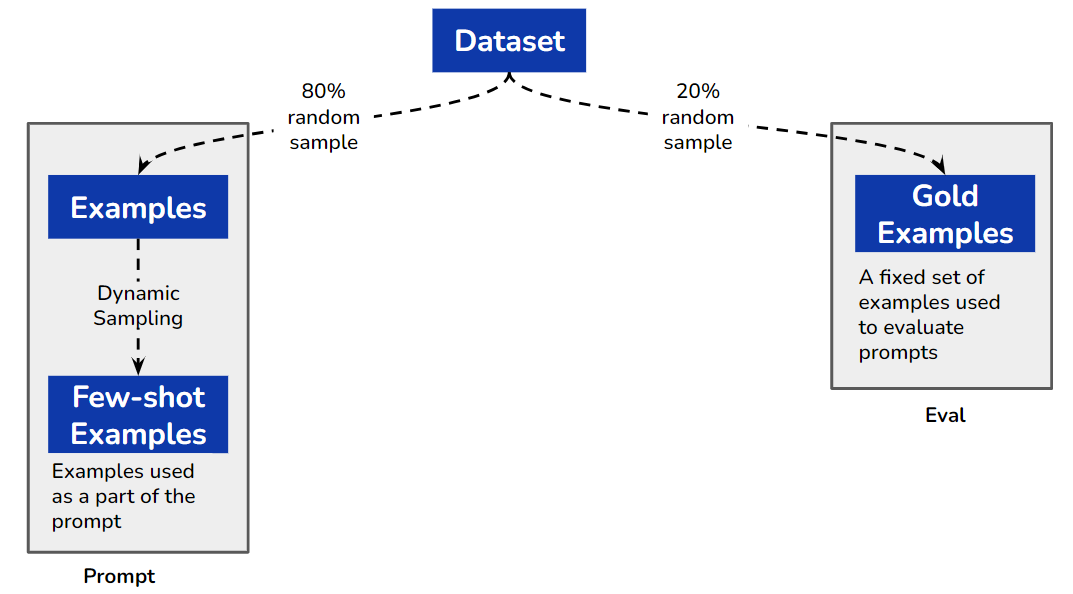

In [36]:
dialogue_summary_examples_df, dialogue_summary_gold_examples_df = train_test_split(
    dialogue_summary_train_df, #<- the full dataset
    test_size=0.2, #<- 20% random sample selected for gold examples
    random_state=42 #<- ensures that the splits are the same for every session
)

Let us sample 50 gold examples that will be held fixed for prompt evaluation (as depicted in the figure above). Note that we are doing this only only for illustration. In practise, large number of gold examples facilitate robust estimates of model performance.

In [37]:
columns_to_select = ['dialogue', 'summary']

gold_examples = (
    dialogue_summary_gold_examples_df.loc[:, columns_to_select]
                                     .sample(50, random_state=42) # ensures that the gold examples are the same between sessions
                                     .to_json(orient='records')
)

In [38]:
len(json.loads(gold_examples))

50

In [39]:
json.loads(gold_examples)[0]

{'dialogue': "#Person1#: Good afternoon Miss, would you be interested in buying more life insurance? You know, you can never get enough.\n#Person2#: I think my husband has some.\n#Person1#: Are you sure he ' s purchased enough insurance for both of you? If something terrible happened with your husband, and he doesn ' t have sufficient insurance, my company does have a policy that could cover you and your husband if something happened to either of you.\n#Person2#: That ' s true. If something happened to my husband, I might lose everything. Both of us have to work to keep our home, car, and our children ' s education. I can ' t afford that by myself.\n#Person1#: Could we sit and look at the policy I mentioned and see if that ' s something suitable for you and your husband?\n#Person2#: Certainly.",
 'summary': "#Person1# recommends #Person2# to buy more life insurance. Even though #Person2#'s husband has some, those insurances can't cover both of them. #Person1#'ll show #Person2# the poli

### Step 3: Derive prompt

In [40]:
system_message = """
Summarize the dialogue mentioned in the user input. Be specific and concise in your summary.
"""

With the system message in place, we can now assemble a few-shot prompt. Notice how the construction of the few-shot prompt mirrors the function we created for classificiation tasks.

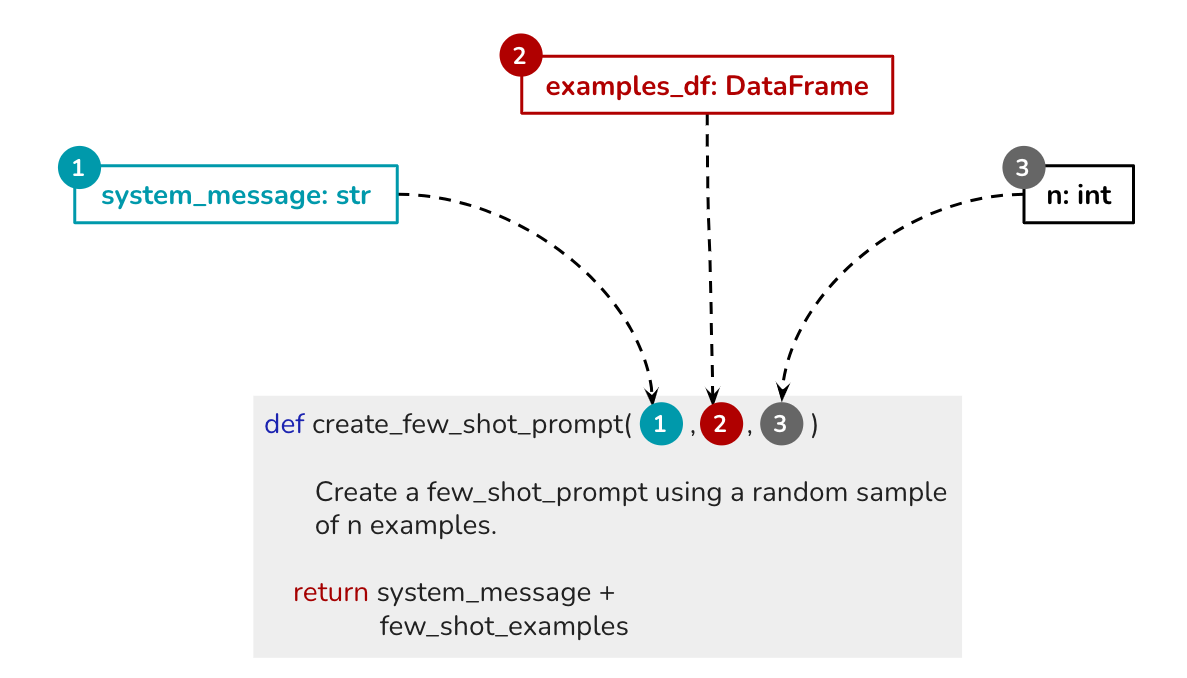

In [41]:
def create_few_shot_prompt(system_message, examples_df, n=8):

    """
    Return a prompt message in the format expected by the Open AI API.
    n examples (default 8) are selected randomly from training data to form the
    few-shot prompt.
    We then loop through each example and parse the dialogue as the user message
    and the summary as the assistant message.

    Args:
        system_message (str): system message with instructions for summarization
        examples_df (DataFrame): A DataFrame with examples (conversation + summary)
        n (int): number of examples of each class to be selected

    Output:
        few_shot_prompt (List): A list of dictionaries in the Open AI prompt format
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]
    columns_to_select = ['dialogue', 'summary']

    examples = (
        examples_df.loc[:, columns_to_select]
                   .sample(n)
                   .to_json(orient='records')
    )

    for example in json.loads(examples):
        user_input_example = example['dialogue']
        assistant_output_example = example['summary']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_input_example
            }
        )

        few_shot_prompt.append(
            {
                'role': 'assistant',
                'content': assistant_output_example
            }
        )

    return few_shot_prompt

Each time this function is executed, a new set of examples is sampled and a prompt is created.

In [42]:
few_shot_prompt = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

In [43]:
num_tokens_from_messages(few_shot_prompt)

1123

We can see that the number of tokens in quite high in the few-shot prompt. This is because of the long conversations used within the few-shot examples.

While we now have a few-shot prompt assembled, we will still need to ascertain that there is little variability in the performance of this prompt (i.e., the BERTScores or ROUGE-L have less variance).

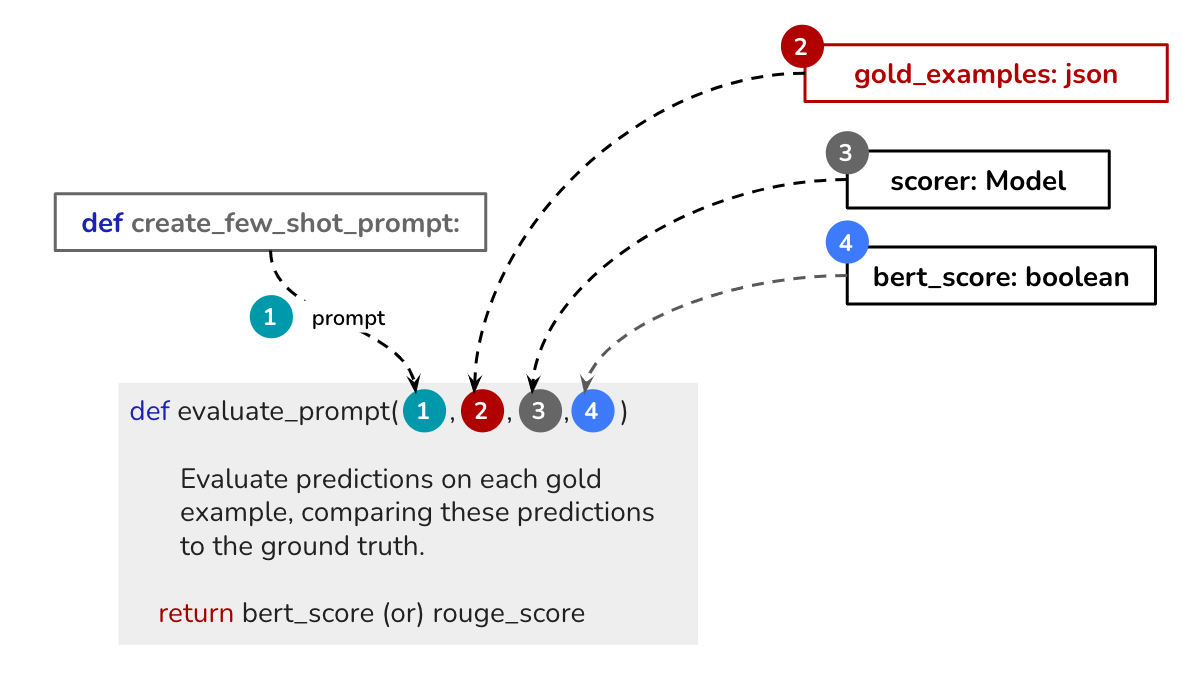

In [44]:
def evaluate_prompt(prompt, gold_examples, scorer, bert_score=False):

    """
    Return the ROUGE score or BERTScore for predictions on gold examples
    For each example we make a prediction using the prompt.
    Gold summaries and the AI generated summaries are aggregated into lists.
    These lists are used by the corresponding scorers to compute metrics.
    Since BERTScore is computed for each candidate-reference pair, we take the
    average F1 score across the gold examples.

    Args:
        prompt (List): list of messages in the Open AI prompt format
        gold_examples (str): JSON string with list of gold examples
        scorer (function): Scorer function used to compute the ROUGE score or the
                           BERTScore
        bert_score (boolean): A flag variable that indicates if BERTScore should
                              be used as the metric.

    Output:
        score (float): BERTScore or ROUGE score computed by comparing model predictions
                       with ground truth
    """

    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        gold_dialogue = example['dialogue']
        user_input = [
            {
                'role':'user',
                'content': gold_dialogue
            }
        ]

        try:
            response = openai.ChatCompletion.create(
                deployment_id=chat_model_id,
                messages=prompt+user_input,
                temperature=0
            )

            prediction = response['choices'][0]['message']['content']

            model_predictions.append(prediction)
            ground_truths.append(example['summary'])

        except Exception as e:
            print(e) # A better error handling mechanism could be implemented
            continue

    if bert_score:
        score = scorer.compute(
            predictions=model_predictions,
            references=ground_truths,
            lang="en",
            rescale_with_baseline=True
        )

        return sum(score['f1'])/len(score['f1'])
    else:
        return scorer.compute(
            predictions=model_predictions,
            references=ground_truths
        )

In [45]:
rouge_scorer = evaluate.load("rouge")
bert_scorer = evaluate.load("bertscore")

In [46]:
evaluate_prompt(
    few_shot_prompt,
    gold_examples,
    rouge_scorer
)

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766


{'rouge1': 0.40869569386563975,
 'rouge2': 0.15534813565698546,
 'rougeL': 0.3288035042532046,
 'rougeLsum': 0.3275832771935082}

Note that the metric we need is [$\text{ROUGE}_L$](https://huggingface.co/spaces/evaluate-metric/rouge) that computes the ROUGE score for the longest common subsequence.

In [47]:
evaluate_prompt(
    few_shot_prompt,
    gold_examples,
    bert_scorer,
    bert_score=True
)

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.49878747867686407

Since this is abstractive summarization, we focus on BERTScore as the evaluation metric. In this example, we get a BERTScore of around 0.45 with a set of 8 examples chosen at random from the training data to form the few-shot prompt. However, this is *one* choice of examples; we will need to run this evaluation multiple times to capture the variation in performance due to variation in the choice of few-shot examples.

As an example, let us run the evaluations 10 times, each time evaluating the model on BERTScore.

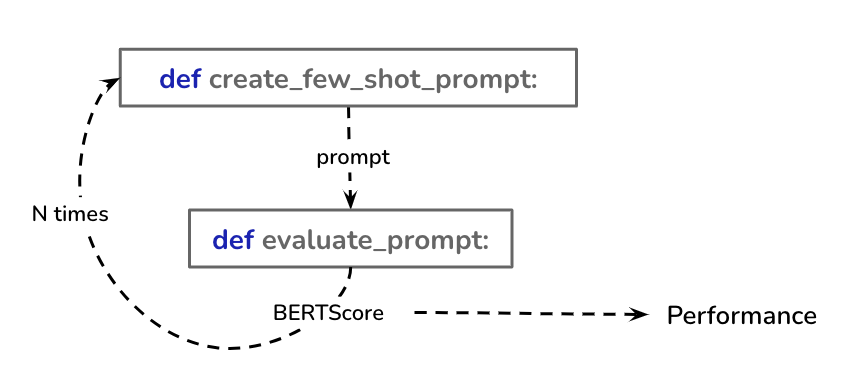

**Reminder: The following code should be run on a GPU runtime to avoid long running times**

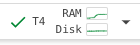

In [48]:
num_eval_runs = 5

In [49]:
few_shot_performance = []

In [50]:
for _ in tqdm(range(num_eval_runs)):

    # For each run, create a new set of examples and compose the few-shot
    # prompt.
    few_shot_prompt = create_few_shot_prompt(
        system_message,
        dialogue_summary_examples_df
    )

    # Compute BERTScore for the prompt assembled.
    # Gold examples remain the same for each evaluation.
    few_shot_bert_score = evaluate_prompt(
        few_shot_prompt,
        gold_examples,
        bert_scorer,
        bert_score=True
    )

    few_shot_performance.append(few_shot_bert_score)

  0%|          | 0/5 [00:00<?, ?it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766


 20%|██        | 1/5 [01:16<05:07, 76.82s/it]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766


 40%|████      | 2/5 [02:31<03:46, 75.67s/it]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766


 60%|██████    | 3/5 [03:38<02:23, 71.54s/it]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766


 80%|████████  | 4/5 [04:41<01:08, 68.43s/it]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766


100%|██████████| 5/5 [05:44<00:00, 68.92s/it]


In [51]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(0.505835784454735, 0.00935407113607358)

Across multiple evaluations, we expect the variability in BERTScore to be less (as is the case here).

Once we identify the correct prompt (in this case, it would amount to running variations of the system message prompt), we need to conduct the two sensitivity checks we saw in the case of text $→$ label tasks.

*Check 1: Bias*

We check if the prompt is generating a biased response by presenting a content free input (usually a blank, the string nothing or N/A). This check also acts as a guardrail for the situation where customer input is improperly received.

In [52]:
bias_test_predictions = []

In [53]:
few_shot_prompt = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

In [54]:
for _ in tqdm(range(25)):

    user_input = [
        {
            'role':'user',
            'content': "' '" #<- content free test input
        }
    ]

    response = openai.ChatCompletion.create(
        deployment_id=chat_model_id,
        messages=few_shot_prompt+user_input,
        temperature=0,
        max_tokens=2
    )

    prediction = response['choices'][0]['message']['content']

    bias_test_predictions.append(prediction)

100%|██████████| 25/25 [00:04<00:00,  5.82it/s]


In [55]:
Counter(bias_test_predictions)

Counter({"I'm": 25})

At best, the model should identify that no dialogue was presented to summarize. At least, it should not give different summaries each time.

*Check 2: Sensitity to number of examples*

To check if the performance of the prompt is sensitive to the number of examples used in the prompt, we vary the number of examples and ascertain that there is no dramatic difference in performance.

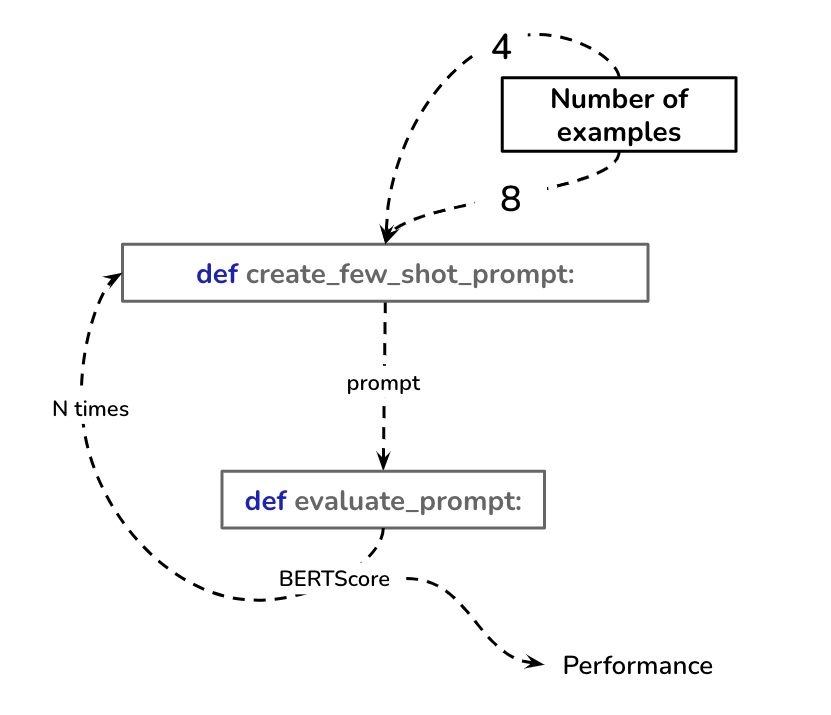

Note that using large number of examples impacts the cost of inference (we pay by token), so we should increase examples only if they have a substantial impact on performance.

In [56]:
sample_size_sensitivity_results = []
num_examples_choice = [4, 8]

In [57]:
for n in tqdm(num_examples_choice):

    for _ in range(5):

        few_shot_prompt = create_few_shot_prompt(
            system_message,
            dialogue_summary_examples_df,
            n
        )

        bert_score_f1 = evaluate_prompt(
            few_shot_prompt,
            gold_examples,
            bert_scorer,
            bert_score=True
        )

        sample_size_sensitivity_results.append(
            {'num_examples': n, 'bert_score_f1': bert_score_f1}
        )

  0%|          | 0/2 [00:00<?, ?it/s]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

 50%|█████     | 1/2 [05:06<05:06, 306.79s/it]

The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766
The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documen

100%|██████████| 2/2 [10:16<00:00, 308.23s/it]


In [58]:
pd.DataFrame(sample_size_sensitivity_results).groupby('num_examples').agg(['mean', 'std'])

bert_score_f1          
                      mean       std
num_examples                        
4                 0.491707  0.011280
8                 0.489212  0.015336

As we can see, the BERTScore is not sensitive to the number of examples chosen to be part of the few-shot prompt. This means that we can now release the few-shot prompt for deployment.

If there was a significant difference in BERTScore, we would choose the number of examples with the highest BERTScore to create the few-shot prompt. At the same time, if we observe high variability, this is an indicator that few-shot prompting is not an ideal solution. In this case we will need more context than that embedded within the few-shot examples.

As part of the release process, it is important to compute the cost incurred per prediction made. This is different from the cost incurred in receiving a prediction from Open AI through API usage.

*Check 3: Cost during deployment*

To estimate deployment costs, let us begin by computing the cost per prediction of a few-shot prompt using the costing information from the [Azure documentation](https://azure.microsoft.com/en-in/pricing/details/cognitive-services/openai-service/).

The logic used to implement the costing model is presented in the following figure.

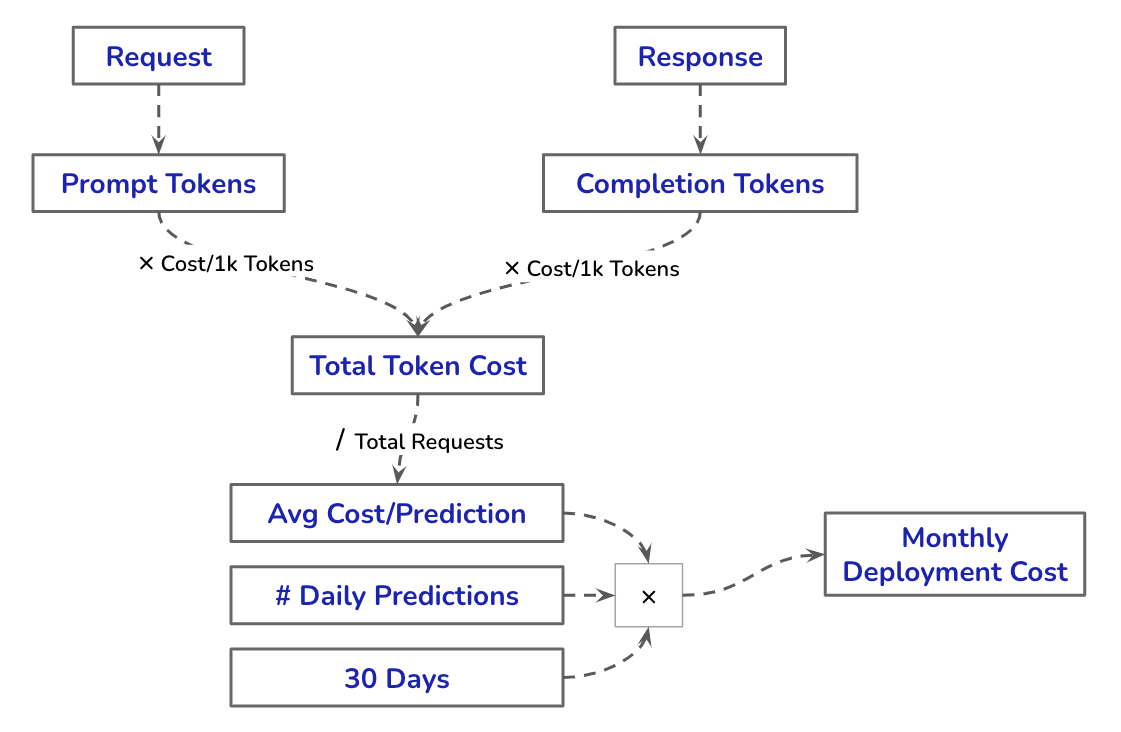

In [59]:
cost_per_1k_tokens_prompt = 0.0015
cost_per_1k_tokens_completion = 0.002
total_token_cost = 0

In [60]:
few_shot_prompt = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

In [61]:
for example in tqdm(json.loads(gold_examples)):
    gold_dialogue = example['dialogue']
    user_input = [
        {
            'role': 'user',
            'content': gold_dialogue
        }
    ]

    try:
        response = openai.ChatCompletion.create(
            deployment_id=chat_model_id,
            messages=few_shot_prompt+user_input,
            temperature=0
        )

        num_prompt_tokens_1k = response["usage"]["prompt_tokens"]/1000
        num_completion_tokens_1k = response["usage"]["completion_tokens"]/1000

        total_token_cost = (total_token_cost +
            num_prompt_tokens_1k * cost_per_1k_tokens_prompt +
            num_completion_tokens_1k * cost_per_1k_tokens_completion
        )

    except Exception as e:
        continue

100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


In [62]:
avg_cost_per_prediction = total_token_cost/len(json.loads(gold_examples))

In [63]:
avg_cost_per_prediction

0.002724740000000001

With this estimate, we can now estimate the monthly cost of deployment, given:
- expected number of predictions per day (i.e., estimated daily traffic).
- number of days in a month (assumed to be 30).

In [64]:
expected_predictions_per_day, days_in_month = 10_000, 30

In [65]:
monthly_deployment_cost = (expected_predictions_per_day * avg_cost_per_prediction) * days_in_month

In [66]:
print(f"Monthly deployment cost: USD {int(monthly_deployment_cost)}")

Monthly deployment cost: USD 817


We can wrap this logic into a Python function that calculates the deployment cost, given a few-shot prompt.

In [67]:
def monthly_deployment_cost(few_shot_prompt, gold_examples,
                            cost_per_1k_tokens_prompt=0.0015,
                            cost_per_1k_tokens_completion=0.002,
                            expected_predictions_per_day=10_000,
                            days_in_month=30):
    total_token_cost = 0

    for example in json.loads(gold_examples):
        gold_dialogue = example['dialogue']
        user_input = [
            {
                'role': 'user',
                'content': gold_dialogue
            }
        ]

        try:
            response = openai.ChatCompletion.create(
                deployment_id=chat_model_id,
                messages=few_shot_prompt+user_input,
                temperature=0
            )

            num_prompt_tokens_1k = response["usage"]["prompt_tokens"]/1000
            num_completion_tokens_1k = response["usage"]["completion_tokens"]/1000

            total_token_cost = (total_token_cost +
                num_prompt_tokens_1k * cost_per_1k_tokens_prompt +
                num_completion_tokens_1k * cost_per_1k_tokens_completion
            )

        except Exception as e:
            continue

    avg_cost_per_prediction = total_token_cost/len(json.loads(gold_examples))
    monthly_deployment_cost = (expected_predictions_per_day * avg_cost_per_prediction) * days_in_month
    return int(monthly_deployment_cost)

In [68]:
avg_monthly_deployment_cost = []

for _ in tqdm(range(5)):

    few_shot_prompt = create_few_shot_prompt(
        system_message,
        dialogue_summary_examples_df
    )

    avg_monthly_deployment_cost.append(
        monthly_deployment_cost(few_shot_prompt, gold_examples)
    )

np.array(avg_monthly_deployment_cost).mean()

100%|██████████| 5/5 [03:25<00:00, 41.06s/it]


998.8

We assemle the few-shot prompt one last time before we release the prompt for deployment.

In [69]:
few_shot_prompt_final = create_few_shot_prompt(
    system_message,
    dialogue_summary_examples_df
)

## Task 2: Question - Answering

Question-Answering (QA) tasks are very common in fields where significant expertise is needed (e.g., medicine, law). In QA tasks, an optional context might be provided to the model in order to guide it to the correct answer. Context is particularly important in domains where there is limited public data (e.g., finance, legal). Providing context is necessary given less domain-specific data in the training corpus. Hence, there is less chance for the model to have seen text from the domain.

There are two important types of QA we want our model to tackle:
- Factual (Objective) QA
- Subjective QA

Subjective QA follows the same format as text summarization. That is, we first assemble a set of questions (e.g., FAQs) and ask experts to annotate these with appropriate answers. Then we present these questions (+ optional context) to the model and use BERTScore to measure how close the output from the model is to the answer written by an expert. We will look at subjective QA more closely when we do Retrieval Augmented Generation (RAG) later.

For now let us focus on factual QA, where the objective is to select the correct answer from a set of multiple choice options provided to the model. For factual QA, the knowledge base that the model was exposed to during pretraining becomes critical.

### Step 1: Define objectives and metrics

Since we will prompt the model to pick the correct answer from a set of options (the objective), we can use accuracy as the metric.

### Step 2: Assemble data

To illustrate multiple-choice question answering, we use a dataset of [medical questions and answers](https://huggingface.co/datasets/medmcqa) that was annotated with a correct answer and an expert explanation. We discard the explanation and focus only on the answer options and the choice of the correct answer.

In [70]:
medmcqa_corpus = load_dataset("medmcqa")

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

In [71]:
medmcqa_corpus

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 182822
    })
    test: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 6150
    })
    validation: Dataset({
        features: ['id', 'question', 'opa', 'opb', 'opc', 'opd', 'cop', 'choice_type', 'exp', 'subject_name', 'topic_name'],
        num_rows: 4183
    })
})

The test data does not have the correct labels, so we choose the validation data as a source of gold examples. Like before, usually we select a dataset from a corpus and then create a examples-gold examples split from this dataset. Here, these steps were already conducted for us.

In [72]:
medmcqa_train_df = medmcqa_corpus['train'].to_pandas()

In [73]:
medmcqa_train_df.sample(5)

,id,question,opa,opb,opc,opd,cop,choice_type,exp,subject_name,topic_name
182530,4e6d187c-6bf9-4871-91b5-942bc2c77697,Pancreatitis is a common complication of which...,Zidovudine,Didanosine,Zalcitabine,Stavudine,1,single,None,Pharmacology,None
57498,dac1c4e9-05f1-41ef-b7b3-57f49b66bfb9,5-Lipo - oxygenase synthesis inhibitor is,Zileuton,Zafirleucast,Monteleucast,Omalizumab,0,single,"(Zileuton) (175, 223-KDT 6th)ZILEUTON -- is a ...",Pharmacology,Asthma
6523,cf7beda5-2909-468d-8966-54036d60e07f,Chemical method of strengthening porcelain\nin...,exchange of aluminium and sodium ions,exchange aluminium and potassium ions,exchange of sodium and potassium ions,none of the above,2,multi,None,Dental,None
88973,569fa45f-47ed-4864-8919-c21089204aac,Which molecule is regarded as carrier of TCA c...,Acetyl CoA,Oxaloacetate,Citrate,ATP,1,single,Oxaloacetate is regarded as: Carrier of TCA cy...,Biochemistry,TCA Cycle
135664,84add83c-7a55-4c18-a61c-93de76aab22c,The patent vitello-intestinal duct most often ...,Mucus,Pus,Urine,Faeces,0,single,None,Surgery,None


As can be seen from the table above, each question has four options (`opa`, `opb`, `opc` and `opd`). Questions might have more than one answer. Questions are also from a wide variety of subjects. Let us focus on single-answer questions for ilustration.

In [74]:
medmcqa_train_df.subject_name.value_counts()

subject_name
Medicine                        17887
Surgery                         16862
Pathology                       14884
Anatomy                         14560
Pharmacology                    13758
Social & Preventive Medicine    11882
Microbiology                    11314
Gynaecology & Obstetrics        10013
Dental                           8938
Physiology                       8830
Biochemistry                     8282
Pediatrics                       8037
Ophthalmology                    6932
Forensic Medicine                5900
ENT                              4919
Psychiatry                       4442
Radiology                        4395
Anaesthesia                      3172
Unknown                          3045
Orthopaedics                     2999
Skin                             1771
Name: count, dtype: int64

In [75]:
medmc_singleqa_train_df = medmcqa_train_df.query("choice_type == 'single'")

In [76]:
medmcqa_examples_df, medmcqa_gold_examples_df = train_test_split(
    medmc_singleqa_train_df, #<- the full dataset
    test_size=0.2, #<- 20% random sample selected for gold examples
    random_state=42, #<- ensures that the splits are the same for every session
    stratify=medmc_singleqa_train_df.subject_name #<- split so that there is equal representation by subject
)

In [77]:
columns_to_select = ['question', 'opa', 'opb', 'opc', 'opd', 'cop']

In [78]:
gold_examples = (
    medmcqa_gold_examples_df.loc[:, columns_to_select]
                            .sample(100, random_state=42) #<- ensures that gold examples are the same for every session
                            .to_json(orient='records')
)

In [79]:
json.loads(gold_examples)[0]

{'question': 'Peripheral edema in CCF is due to -',
 'opa': 'Increased hydrostatic pressure',
 'opb': 'Increased osmotic pressure',
 'opc': 'Decreased proteins',
 'opd': 'Decreased aldosterone',
 'cop': 0}

### Step 3: Derive prompt

In [80]:
few_shot_system_message = """
Pick the correct option for the question presented in the input.
Each question will be from the medical domain and will have only one correct answer.
Questions will begin with the keyword ###Question.
The answer to these questions needs to be picked from four options (0, 1, 2, and 3) presented in the section beginning with ###Options.
Remember that there is only one correct answer for each question.
Respond only with the number of the correct option, that is, 0, 1, 2, or 3.
"""

In [81]:
user_message_template ="""
###Question
{question}

###Options
0. {opa}
1. {opb}
2. {opc}
3. {opd}
"""

Examples could be assembled like so:

In [82]:
examples = (
    medmcqa_examples_df.loc[:, columns_to_select]
                       .sample(16)
                       .to_json(orient='records')
)

In [83]:
json.loads(examples)

[{'question': 'Amatoxins in mushroom poisoning acts by inhibiting-',
  'opa': 'DNA',
  'opb': 'mRNA',
  'opc': 'Adenosine',
  'opd': 'G-proteins',
  'cop': 1},
 {'question': 'A 68-year-old man with prostate cancer and bone metastases presents with shaking chills and fever. The peripheral WBC count is 1,000/mL (normal = 4,000 to 11,000/mL). Which of the following terms best describes this hematologic finding?',
  'opa': 'Leukocytosis',
  'opb': 'Leukopenia',
  'opc': 'Neutrophilia',
  'opd': 'Leukemoid reaction',
  'cop': 1},
 {'question': 'Mousy odour urine is present in:',
  'opa': 'Phenylketonuria',
  'opb': 'Maple syrup urine disease',
  'opc': 'Tyrosinemia',
  'opd': 'Homocystinuria',
  'cop': 0},
 {'question': 'Location of root canals is best done by endodontic',
  'opa': 'Probe',
  'opb': 'Explorer',
  'opc': 'Ultrasonic system',
  'opd': 'File',
  'cop': 1},
 {'question': 'Tattoo marks are not visible during autopsy as confirmed by relatives where tattooing can be check next dur

Let us wrap this logic into a function to create a few-shot prompt.

In [84]:
def create_few_shot_prompt(system_message, user_message_template, examples_df, n=8):

    """
    Return a prompt message in the format expected by the Open AI API.
    n examples are selected randomly from training data to form the few-shot
    prompt.
    We then loop through each example and parse the question and options as the
    user message and the correct option as the assistant message.
    """

    few_shot_prompt = [{'role':'system', 'content': system_message}]
    columns_to_select = ['question', 'opa', 'opb', 'opc', 'opd', 'cop']

    examples = (
        examples_df.loc[:, columns_to_select]
                   .sample(n)
                   .to_json(orient='records')
    )

    for example in json.loads(examples):
        example_question = example['question']
        option_a = example['opa']
        option_b = example['opb']
        option_c = example['opc']
        option_d = example['opd']

        assistant_output_example = example['cop']

        few_shot_prompt.append(
            {
                'role': 'user',
                'content': user_message_template.format(
                    question=example_question,
                    opa=option_a,
                    opb=option_b,
                    opc=option_c,
                    opd=option_d
                )
            }
        )

        few_shot_prompt.append(
            {
                'role': 'assistant',
                'content': str(assistant_output_example) # convert integer to string since GPT accepts only text input
            }
        )

    return few_shot_prompt

In [85]:
few_shot_prompt = create_few_shot_prompt(
    few_shot_system_message,
    user_message_template,
    medmcqa_examples_df
)

In [86]:
num_tokens_from_messages(few_shot_prompt)

571

In [87]:
def evaluate_prompt(prompt, gold_examples, user_message_template):

    """
    Return the accuracy for predictions on gold examples.
    For each example we make a prediction using the prompt.
    Gold answers and the AI generated answers are aggregated into lists.
    The numpy .mean() function is used to compute accuracy by comparing these
    two lists.
    """

    model_predictions, ground_truths = [], []

    for example in json.loads(gold_examples):
        gold_question = example['question']
        gold_option_a = example['opa']
        gold_option_b = example['opb']
        gold_option_c = example['opc']
        gold_option_d = example['opd']

        user_input = [
            {
                'role':'user',
                'content': user_message_template.format(
                    question=gold_question,
                    opa=gold_option_a,
                    opb=gold_option_b,
                    opc=gold_option_c,
                    opd=gold_option_d
                )
            }
        ]

        try:
            response = openai.ChatCompletion.create(
                deployment_id=chat_model_id,
                messages=prompt+user_input,
                temperature=0
            )

            prediction = response['choices'][0]['message']['content']

            model_predictions.append(int(prediction)) # string converted back to integer
            ground_truths.append(example['cop'])

        except Exception as e:
            print(e) # A better error handling mechanism could be implemented
            continue

    return (np.array(model_predictions) == np.array(ground_truths)).mean()

In [88]:
evaluate_prompt(few_shot_prompt, gold_examples, user_message_template)

0.76

However, this accuracy is for *one* iteration. Let us see how the accuracy varies across different selection of few-shot examples.

In [89]:
few_shot_performance = []
num_eval_runs = 5

for _ in tqdm(range(num_eval_runs)):

    # Assemble the few shot prompt
    few_shot_prompt = create_few_shot_prompt(
        few_shot_system_message,
        user_message_template,
        medmcqa_examples_df
    )

    # Evaluate prompt accuracy on gold examples
    few_shot_accuracy = evaluate_prompt(
        few_shot_prompt,
        gold_examples,
        user_message_template
    )

    few_shot_performance.append(few_shot_accuracy)

100%|██████████| 5/5 [01:14<00:00, 14.83s/it]


In [90]:
np.array(few_shot_performance).mean(), np.array(few_shot_performance).std()

(0.728, 0.0040000000000000036)

With this measure of accuracy, let us now run the usual checks, that is, bias and sensitivity to number of examples.

*Check 1: Bias*

In [91]:
bias_test_predictions = []

In [92]:
few_shot_prompt = create_few_shot_prompt(
        few_shot_system_message,
        user_message_template,
        medmcqa_examples_df
)

In [93]:
for _ in tqdm(range(25)):

    user_input = [
        {
            'role':'user',
            'content': "' '" #<- content free test input
        }
    ]

    response = openai.ChatCompletion.create(
        deployment_id=chat_model_id,
        messages=few_shot_prompt+user_input,
        temperature=0,
        max_tokens=2
    )

    prediction = response['choices'][0]['message']['content']

    bias_test_predictions.append(prediction)

100%|██████████| 25/25 [00:02<00:00,  8.36it/s]


In [94]:
Counter(bias_test_predictions)

Counter({'': 25})

From the output above, there is no evidence of bias.

*Check 2: Sensitivity to number of examples*

In [95]:
sample_size_sensitivity_results = []
num_examples_choice = [4, 8, 16, 32]

In [96]:
for num_examples in tqdm(num_examples_choice):

    for _ in range(5):

        few_shot_prompt = create_few_shot_prompt(
            few_shot_system_message,
            user_message_template,
            medmcqa_examples_df,
            n=num_examples
        )

        few_shot_accuracy = evaluate_prompt(
            few_shot_prompt,
            gold_examples,
            user_message_template
        )

        sample_size_sensitivity_results.append(
            {'num_examples': num_examples, 'accuracy': few_shot_accuracy}
        )

  0%|          | 0/4 [00:00<?, ?it/s]

invalid literal for int() with base 10: '0 (Clostridium difficile)'


100%|██████████| 4/4 [05:37<00:00, 84.44s/it]


In [97]:
pd.DataFrame(sample_size_sensitivity_results).groupby('num_examples').agg(['mean', 'std'])

accuracy          
                  mean       std
num_examples                    
4             0.725475  0.014594
8             0.738000  0.008367
16            0.748000  0.022804
32            0.734000  0.015166

As we can see from the table above, there is not much difference in accuracy due to the number of examples chosen to be a part of the few-shot prompt.

We assemble the few-shot prompt one last time for deployment.

In [98]:
few_shot_prompt_final = create_few_shot_prompt(
        few_shot_system_message,
        user_message_template,
        medmcqa_examples_df,
        n=16
)

In [99]:
few_shot_prompt_final

[{'role': 'system',
  'content': '\nPick the correct option for the question presented in the input.\nEach question will be from the medical domain and will have only one correct answer.\nQuestions will begin with the keyword ###Question.\nThe answer to these questions needs to be picked from four options (0, 1, 2, and 3) presented in the section beginning with ###Options.\nRemember that there is only one correct answer for each question.\nRespond only with the number of the correct option, that is, 0, 1, 2, or 3.\n'},
 {'role': 'user',
  'content': '\n###Question\nDefinition of health given by WHO includes which of the following dimensions:\n\n###Options\n0. Social\n1. Physical\n2. Mental\n3. Emotional\n'},
 {'role': 'assistant', 'content': '1'},
 {'role': 'user',
  'content': '\n###Question\nIf after 2 months of conventional antituberculous therapy, sputum smear examination is negative but culture is positive, it indicates -\n\n###Options\n0. Treatment failure\n1. Transitional resist

# Summary

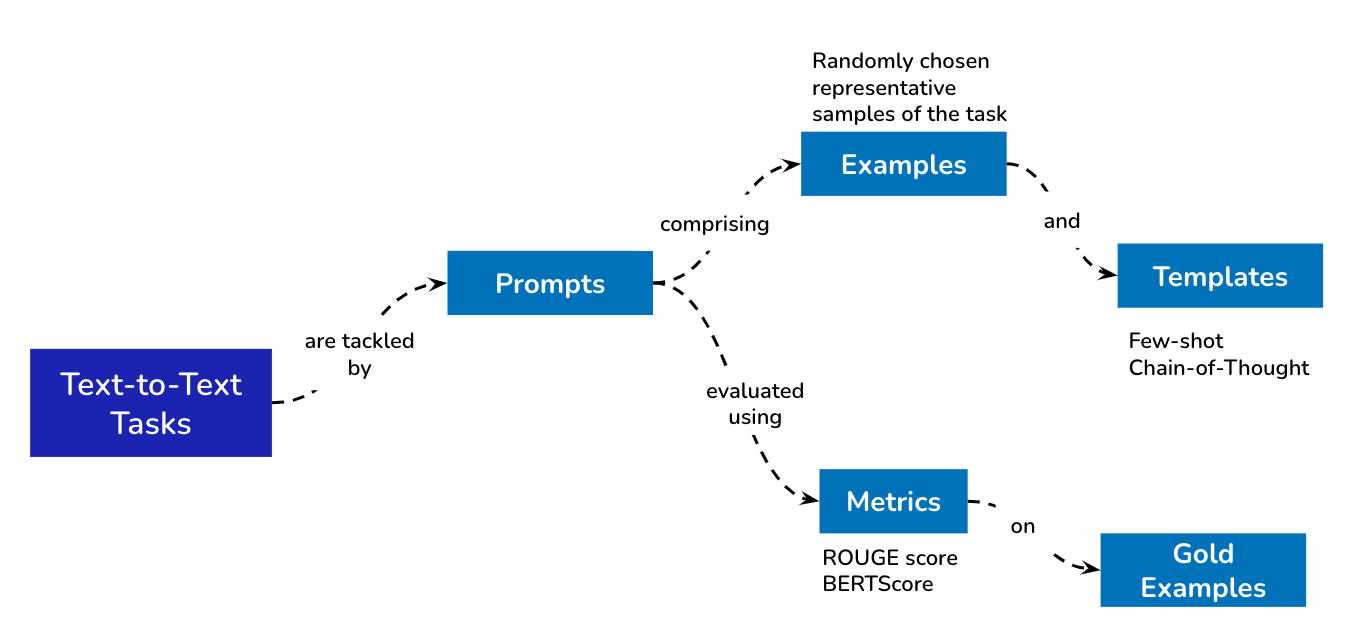

# Additional Material

This is additional code that was used to create visuals for the exposition on ROUGE score and BERTScore.

In [100]:
import string

In [101]:
def remove_punctuation_and_lowercase(sentence):
    # Create a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)

    # Remove punctuation and convert to lowercase
    cleaned_sentence = sentence.translate(translator).lower()

    return cleaned_sentence

In [102]:
def generate_ngrams(sentence, n):

    cleaned_sentence = remove_punctuation_and_lowercase(sentence)

    # Tokenize the sentence into words
    words = cleaned_sentence.split()

    # Generate n-grams
    ngrams = [tuple(words[i:i + n]) for i in range(len(words) - n + 1)]

    return ngrams

In [103]:
def find_matching_ngrams(sentence1, sentence2, n):
    # Generate n-grams for both sentences
    ngrams1 = generate_ngrams(sentence1, n)
    ngrams2 = generate_ngrams(sentence2, n)

    # Convert n-grams to sets for faster intersection
    ngram_set1 = set(ngrams1)
    ngram_set2 = set(ngrams2)

    # Find matching n-grams
    matching_ngrams = ngram_set1.intersection(ngram_set2)

    return matching_ngrams

In [104]:
def len_of_ngrams(sentence, n):
    ngrams = set(generate_ngrams(sentence, n))
    return len(ngrams)

In [105]:
ai_generated_summary = "Colossal disappointment with constant glitches, defects, and a malfunctioning camera."
human_generated_summary = "Incredibly let down by the never-ending issues – glitches, defects, and a camera that just won't cooperate."

In [106]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    1
)

print("Matching 1-grams:", matching_ngrams)
print("Number of 1-grams (human):", len_of_ngrams(human_generated_summary, 1)) # For ROUGE
print("Number of 1-grams (AI):", len_of_ngrams(ai_generated_summary, 1))

Matching 1-grams: {('glitches',), ('camera',), ('and',), ('defects',), ('a',)}
Number of 1-grams (human): 17
Number of 1-grams (AI): 10


In [107]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    2
)

print("Matching 2-grams:", matching_ngrams)
print("Number of 2-grams (human):", len_of_ngrams(human_generated_summary, 2)) # For ROUGE
print("Number of 2-grams (AI):", len_of_ngrams(ai_generated_summary, 2))

Matching 2-grams: {('glitches', 'defects'), ('defects', 'and'), ('and', 'a')}
Number of 2-grams (human): 16
Number of 2-grams (AI): 9


In [108]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    3
)

print("Matching 3-grams:", matching_ngrams)
print("Number of 3-grams (human):", len_of_ngrams(human_generated_summary, 3))
print("Number of 3-grams (AI):", len_of_ngrams(ai_generated_summary, 3))

Matching 3-grams: {('glitches', 'defects', 'and'), ('defects', 'and', 'a')}
Number of 3-grams (human): 15
Number of 3-grams (AI): 8


In [109]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    4
)

print("Matching 4-grams:", matching_ngrams)
print("Number of 4-grams (human):", len_of_ngrams(human_generated_summary, 4))
print("Number of 4-grams (AI):", len_of_ngrams(ai_generated_summary, 4))

Matching 4-grams: {('glitches', 'defects', 'and', 'a')}
Number of 4-grams (human): 14
Number of 4-grams (AI): 7


In [110]:
matching_ngrams = find_matching_ngrams(
    ai_generated_summary,
    human_generated_summary,
    5
)

print("Matching 5-grams:", matching_ngrams)
print("Number of 5-grams (human):", len_of_ngrams(human_generated_summary, 5))
print("Number of 5-grams (AI):", len_of_ngrams(ai_generated_summary, 5))

Matching 5-grams: set()
Number of 5-grams (human): 13
Number of 5-grams (AI): 6


In [111]:
rouge_score = evaluate.load("rouge")

In [112]:
rouge_score.compute(
    predictions=[ai_generated_summary],
    references=[human_generated_summary],
    tokenizer=lambda x: remove_punctuation_and_lowercase(x).split()
)

{'rouge1': 0.37037037037037035,
 'rouge2': 0.24000000000000005,
 'rougeL': 0.37037037037037035,
 'rougeLsum': 0.37037037037037035}

In [113]:
r_lcs, p_lcs = 5/17, 5/10
(2 * r_lcs * p_lcs)/(r_lcs + p_lcs)

0.37037037037037035

In [114]:
bert_score = evaluate.load("bertscore")

In [115]:
bert_score.compute(
    predictions=[ai_generated_summary],
    references=[human_generated_summary],
    lang='en'
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'precision': [0.9408690929412842],
 'recall': [0.9137743711471558],
 'f1': [0.9271237850189209],
 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.40.2)'}

In [116]:
from bert_score import score, plot_example

In [117]:
ai_generated_summary = "Major issues, malfunctioning camera."
human_generated_summary = "Severely disappointed, constant problems."

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


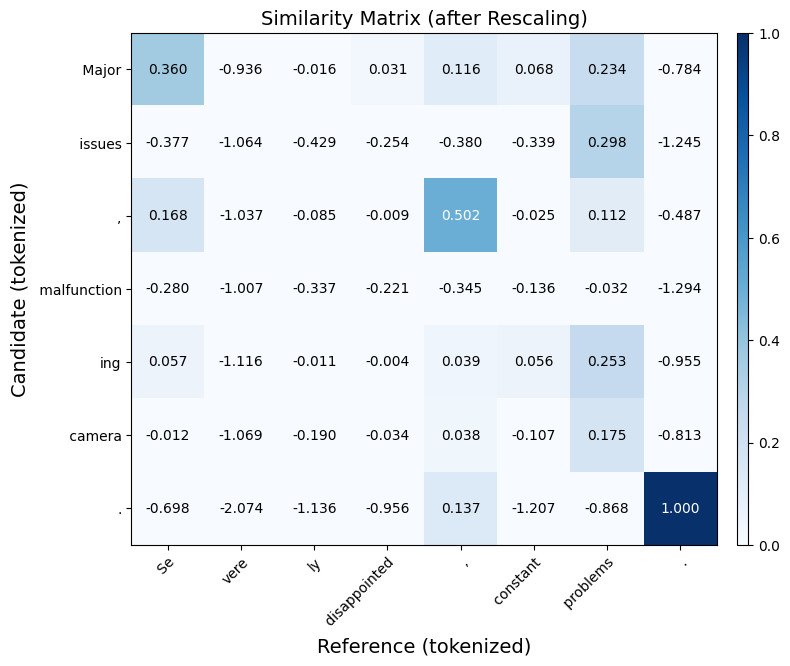

In [118]:
plot_example(
    ai_generated_summary,
    human_generated_summary,
    lang="en",
    rescale_with_baseline=True
)

In [119]:
P, R, F1 = score(
    [ai_generated_summary],
    [human_generated_summary],
    lang="en",
    rescale_with_baseline=True
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [120]:
P, R, F1

(tensor([0.3640]), tensor([0.1705]), tensor([0.2666]))

In [121]:
(2 * P * R)/(P + R) # This is then rescaled to reach 0.2666

tensor([0.2322])